In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from timestamps import BeeTimestamps, segments_to_features_and_labels, randomize_segments, balance_segments
import matplotlib.pyplot as plt
import models

SEED = 2
SEGMENT_SIZE = 16
events = ['swarming', 'feeding', 'honey']
timestamps = BeeTimestamps(
    'timestamps-v4.json', 
    './dataset/transformed_populated/interval_15m', 
    events=events, 
    features=['temp_ratio', 'weight_kg_3_pct'],
    step=1
)
segments = timestamps.get_segments_for_minor_events(
    segment_size=SEGMENT_SIZE, 
    hours=8
)
print("Segments: ", len(segments))
print(f"Segments with swarming: {len([segment for segment in segments if segment.get_label()['swarming'] == 1])}")
print(f"Segments with feeding: {len([segment for segment in segments if segment.get_label()['feeding'] == 1])}")
print(f"Segments with treatment: {len([segment for segment in segments if segment.get_label()['treatment'] == 1])}")
print(f"Segments with honey: {len([segment for segment in segments if segment.get_label()['honey'] == 1])}")

Segments:  1591
Segments with swarming: 120
Segments with feeding: 419
Segments with treatment: 0
Segments with honey: 24


In [2]:
random_segments = randomize_segments(segments, seed=SEED)
balanced_segments = balance_segments(random_segments, events=events, min_count=120)
print(f"Balanced segments: {len(balanced_segments)}")

features, labels = segments_to_features_and_labels(balanced_segments)
print(f"Features: {features.shape}, Labels: {labels.shape}")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=SEED)
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
print(f"Sequence length: {sequence_length}, N features: {n_features}, N outputs: {n_outputs}")

Balanced segments: 384
Features: (384, 16, 2), Labels: (384, 3)
Sequence length: 16, N features: 2, N outputs: 3


In [3]:
train_positive = np.sum(np.any(y_train == 1, axis=1))
test_positive = np.sum(np.any(y_test == 1, axis=1))
training_samples_with_swarming = np.sum(np.all(y_train == [1, 0, 0], axis=1))
test_samples_with_swarming = np.sum(np.all(y_test == [1, 0, 0], axis=1))
training_samples_with_feeding = np.sum(np.all(y_train == [0, 1, 0], axis=1))
test_samples_with_feeding = np.sum(np.all(y_test == [0, 1, 0], axis=1))
training_samples_with_honey = np.sum(np.all(y_train == [0, 0, 1], axis=1))
test_samples_with_honey = np.sum(np.all(y_test == [0, 0, 1], axis=1))
print(f"Training samples with positive labels: {train_positive} out of {len(y_train)} ({train_positive/len(y_train)*100:.1f}%)")
print(f"Test samples with positive labels: {test_positive} out of {len(y_test)} ({test_positive/len(y_test)*100:.1f}%)")
print()
print(f"Training samples with swarming event: {training_samples_with_swarming} out of {len(y_train)} ({training_samples_with_swarming/len(y_train)*100:.1f}%)")
print(f"Test samples with swarming event: {test_samples_with_swarming} out of {len(y_test)} ({test_samples_with_swarming/len(y_test)*100:.1f}%)")
print(f"Training samples with feeding event: {training_samples_with_feeding} out of {len(y_train)} ({training_samples_with_feeding/len(y_train)*100:.1f}%)")
print(f"Test samples with feeding event: {test_samples_with_feeding} out of {len(y_test)} ({test_samples_with_feeding/len(y_test)*100:.1f}%)")
print(f"Training samples with honey event: {training_samples_with_honey} out of {len(y_train)} ({training_samples_with_honey/len(y_train)*100:.1f}%)")
print(f"Test samples with honey event: {test_samples_with_honey} out of {len(y_test)} ({test_samples_with_honey/len(y_test)*100:.1f}%)")


Training samples with positive labels: 207 out of 307 (67.4%)
Test samples with positive labels: 57 out of 77 (74.0%)

Training samples with swarming event: 98 out of 307 (31.9%)
Test samples with swarming event: 22 out of 77 (28.6%)
Training samples with feeding event: 91 out of 307 (29.6%)
Test samples with feeding event: 29 out of 77 (37.7%)
Training samples with honey event: 18 out of 307 (5.9%)
Test samples with honey event: 6 out of 77 (7.8%)


In [4]:
model = models.lstm_v1(
    SEGMENT_SIZE=SEGMENT_SIZE, 
    sequence_length=sequence_length, 
    n_features=n_features, 
    n_outputs=n_outputs
)

history = model.fit(X_train, y_train,
    epochs=180,
    batch_size=16,
    validation_data=(X_test, y_test),
    # callbacks=[early_stopping]
)

Epoch 1/180


/Users/oleks/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3982 - loss: 0.6080 - val_accuracy: 0.5455 - val_loss: 0.5532
Epoch 2/180
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6410 - loss: 0.5067 - val_accuracy: 0.3766 - val_loss: 0.5251
Epoch 3/180
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4058 - loss: 0.4631 - val_accuracy: 0.5844 - val_loss: 0.5173
Epoch 4/180
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6564 - loss: 0.4691 - val_accuracy: 0.6234 - val_loss: 0.5091
Epoch 5/180
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5044 - loss: 0.4654 - val_accuracy: 0.6364 - val_loss: 0.4992
Epoch 6/180
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6168 - loss: 0.4530 - val_accuracy: 0.3896 - val_loss: 0.4943
Epoch 7/180
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5834 - loss: 0.4321 - val_accuracy: 0.7403 - val_loss: 0.6906
Epoch 8/180
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3494 - loss: 0.6387 - val_accuracy: 0.3766 - val_l

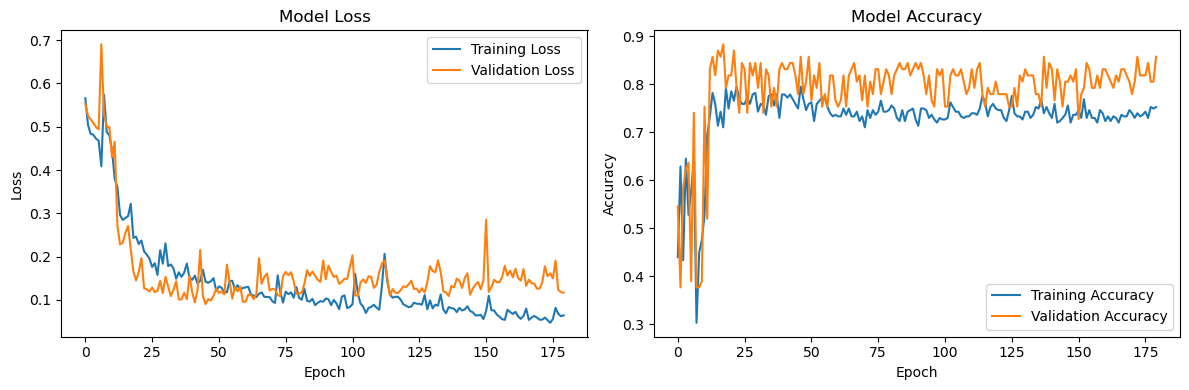

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.1472 

Test accuracy: 0.8571


In [5]:
models.visualize_training(history)
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_accuracy:.4f}')

In [6]:
# For multi-label classification, we need to evaluate each class separately
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report for each event type
for i, event in enumerate(events):
    print(f"\nClassification Report for {event}:")
    print(classification_report(y_test[:, i], y_pred_classes[:, i]))
    
    # Calculate and print accuracy for this event
    accuracy = accuracy_score(y_test[:, i], y_pred_classes[:, i])
    print(f"Accuracy for {event}: {accuracy:.4f}")

# Print overall accuracy (all classes predicted correctly)
overall_accuracy = np.all(y_test == y_pred_classes, axis=1).mean()
print(f"\nOverall accuracy (all classes correct): {overall_accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Classification Report for swarming:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.88      1.00      0.94        22

    accuracy                           0.96        77
   macro avg       0.94      0.97      0.95        77
weighted avg       0.97      0.96      0.96        77

Accuracy for swarming: 0.9610

Classification Report for feeding:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.96      0.90      0.93        29

    accuracy                           0.95        77
   macro avg       0.95      0.94      0.94        77
weighted avg       0.95      0.95      0.95        77

Accuracy for feeding: 0.9481

Classification Report for honey:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00